# Taxi trips count prediction

The task is to create a model that predicts the count of taxi trips for the next hour in [Chicago's community areas](https://en.wikipedia.org/wiki/Community_areas_in_Chicago).  
  
Links to the datasets:  
https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz  
https://data.cityofchicago.org/Transportation/Taxi-Trips-2023/e55j-2ewb

## Load libraries and data

In [1]:
import re
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import date_format, col, count, countDistinct, date_trunc, isnull, lag
from pyspark.sql.functions import max as spark_max
from pyspark.sql.functions import median, mode
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import to_timestamp, when
from pyspark.sql.window import Window
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm

from lib.time_series_processing import TSDataManager

In [2]:
!pip install -q catboost
from catboost import CatBoostRegressor

In [3]:
!pip install -q lightgbm==3.3.5
import lightgbm as lgb

In [4]:
plt.style.use("fivethirtyeight")
plt_params = {
    "axes.titlesize": "18",
    "axes.labelsize": "15",
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "xtick.labelsize": "13",
    "ytick.labelsize": "13",
    "legend.fontsize": "13",
    "lines.linewidth": "2.0",
}

plt.rcParams.update(plt_params)

In [5]:
warnings.simplefilter("ignore")

In [6]:
# reload modules before execution

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np

np.random.seed(42)

In [9]:
APP_NAME = "taxi"
SPARK_MASTER_IP = "172.18.0.2"

PAYMENT_TYPE_THRESHOLD = 1000
TAXI_COMPANY_THRESHOLD = 100
TEST_SIZE = 0.15
START_DATE = "2022-01-08"  # we use trips count with 1 week lag

In [10]:
spark = (
    SparkSession.builder.appName(APP_NAME)
    .config("spark.sql.repl.eagerEval.enabled", True)
    .master(f"spark://{SPARK_MASTER_IP}:7077")
    .config("spark.executor.cores", 2)
    .config("spark.task.cpus", 2)
    .config("spark.executor.memory", "3g")
    .getOrCreate()
)

In [11]:
taxi_2022 = spark.read.load("data/trips_2022.csv", format="csv", header="true", inferSchema="true")

In [12]:
taxi_2023 = spark.read.load("data/trips_2023.csv", format="csv", header="true", inferSchema="true")

## Data cleaning

First step is to remove illogical and erroneous values in data, as well as to delete redundant columns.

In [13]:
taxi_2022.columns

['Trip ID',
 'Taxi ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Census Tract',
 'Dropoff Census Tract',
 'Pickup Community Area',
 'Dropoff Community Area',
 'Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total',
 'Payment Type',
 'Company',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Pickup Centroid Location',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude',
 'Dropoff Centroid  Location']

Converting the trip data to datetime format and removing excessive trips:

In [14]:
taxi_2022 = taxi_2022.withColumn("Trip Start Timestamp", to_timestamp(col("Trip Start Timestamp"), "M/d/yyyy h:m:s a"))

taxi_2022 = taxi_2022.filter(date_format(col("Trip Start Timestamp"), "yyyy-MM-dd") < "2023-01-01")

In [15]:
taxi_2023 = taxi_2023.withColumn("Trip Start Timestamp", to_timestamp(col("Trip Start Timestamp"), "M/d/yyyy h:m:s a"))

taxi_2023 = taxi_2023.filter(date_format(col("Trip Start Timestamp"), "yyyy-MM-dd") < "2023-08-01")

Joining data for 2022/2023 and removing columns with useless information:

In [16]:
taxi = taxi_2022.union(taxi_2023)

In [17]:
taxi = taxi.drop(*["Pickup Centroid Location", "Dropoff Centroid  Location", "Trip ID", "Trip End Timestamp"])

### Money features

Remove rows where total cost of trip differs significantly from the sum of payments:

In [18]:
# taxi.filter(taxi['Trip Total'] - (taxi['Fare'] + taxi['Tips'] + taxi['Tolls'] + taxi['Extras']) > 3).count()
# 412

In [19]:
taxi = taxi.filter(taxi["Trip Total"] - (taxi["Fare"] + taxi["Tips"] + taxi["Tolls"] + taxi["Extras"]) < 3)

### Time and distance features

Add a new feature (**Mean Speed**). Remove entries where mean speed is more than 70 mph, as this is the speed limit in Chicago and its proximity.

In [20]:
taxi = taxi.withColumn("Mean Speed", col("Trip Miles") / (col("Trip Seconds") / 3600))

In [21]:
# taxi.filter(col("Mean Speed") > 70).count()
# 12359

In [22]:
taxi = taxi.filter(col("Mean Speed") <= 70)

### Categorial features

Remove rows with rare company or payment type.

In [23]:
# taxi.agg(countDistinct(col('Taxi ID')))

In [24]:
# taxi.agg(countDistinct(col('Company')))

In [25]:
company_counts = taxi.groupBy("Company").count()
filtered_companies = company_counts.filter(company_counts["count"] < TAXI_COMPANY_THRESHOLD)
companies_to_drop = filtered_companies.select("Company")

In [26]:
taxi = taxi.join(companies_to_drop, on="Company", how="left_anti")

In [27]:
payment_type_counts = taxi.groupBy("Payment Type").count()
filtered_payment_types = payment_type_counts.filter(payment_type_counts["count"] < PAYMENT_TYPE_THRESHOLD)
payment_types_to_drop = filtered_payment_types.select("Payment Type")

In [28]:
taxi = taxi.join(payment_types_to_drop, on="Payment Type", how="left_anti")

## Data processing

In order to predict values for the next hour in a given community area, the data needs to be properly transformed.  
First, the gaps will be filled, then the following transformations will be performed for the dataset features:

* [x] `Latitudes / Longitudes`: drop
* [x] `Taxi ID`: unique taxi ids for the current hour and current community area  
* [x] `Pickup / Dropoff census tract`: unique count
* [x] `Trip seconds`: aggregate, median  
* [x] `Trip miles`: aggregate, median  
* [x] `Money factors`: aggregate, median  
* [x] `Census tracts`: mode
* [x] `Payment type / Company`: frequency of values within an hour

Feature engineering:  
* [x] Trips count, trip total rolling mean and lags
* [x] Time features (dow, hour)

### Gaps

For missing community areas, use the value 100:

In [29]:
taxi = taxi.fillna(100, subset=["Pickup Community Area"])
taxi = taxi.fillna(100, subset=["Dropoff Community Area"])

Before imputation, save geo features for 2023 for further investigation.

In [30]:
geo_features_pickup = taxi.filter(date_format(col("Trip Start Timestamp"), "yyyy-MM-dd") >= "2023-01-01").select(
    "Pickup Community Area",
    "Pickup Census Tract",
    "Pickup Centroid Latitude",
    "Pickup Centroid Longitude",
)

In [31]:
MULTIPLIER = 1.001

In [32]:
# taxi.select([count(when(isnull(c), c)).alias(c) for c in taxi.columns])

For missing latitude / longitude / census tract, use the max value in the feature column, multiplied by 1.001:

In [33]:
max_values = taxi.select(
    spark_max(col("Pickup Centroid Latitude")).alias("max_pc_lat"),
    spark_max(col("Pickup Centroid Longitude")).alias("max_pc_lon"),
    spark_max(col("Dropoff Centroid Latitude")).alias("max_dc_lat"),
    spark_max(col("Dropoff Centroid Longitude")).alias("max_dc_lon"),
    spark_max(col("Pickup Census Tract")).alias("max_pcm"),
    spark_max(col("Dropoff Census Tract")).alias("max_dcm"),
).first()

In [34]:
max_pc_lat = max_values["max_pc_lat"] * MULTIPLIER
max_pc_lon = max_values["max_pc_lon"] * MULTIPLIER
max_dc_lat = max_values["max_dc_lat"] * MULTIPLIER
max_dc_lon = max_values["max_dc_lon"] * MULTIPLIER

max_pcm = round(max_values["max_pcm"] * MULTIPLIER)
max_dcm = round(max_values["max_dcm"] * MULTIPLIER)

In [35]:
taxi = taxi.fillna(max_pc_lat, subset=["Pickup Centroid Latitude"])
taxi = taxi.fillna(max_pc_lon, subset=["Pickup Centroid Longitude"])
taxi = taxi.fillna(max_dc_lat, subset=["Dropoff Centroid Latitude"])
taxi = taxi.fillna(max_dc_lon, subset=["Dropoff Centroid Longitude"])

taxi = taxi.fillna(max(max_pcm, max_dcm), subset=["Pickup Census Tract", "Dropoff Census Tract"])

For money features, impute the missing values with median value in column.

In [36]:
from pyspark.ml.feature import Imputer

columns_to_fill = [
    "Fare",
    "Tips",
    "Tolls",
    "Extras",
    "Trip Total",
]

imputer = Imputer(inputCols=columns_to_fill, outputCols=[col for col in columns_to_fill]).setStrategy("median")

taxi = imputer.fit(taxi).transform(taxi)

### Aggregating non-time features

Group by hour and location, then create unique, aggregate, median, mode and frequency features.

In [37]:
grouped = taxi.groupBy(
    date_trunc("hour", col("Trip Start Timestamp")).alias("date"), col("Pickup Community Area").alias("location")
)

#### Data transformation

##### distinct

In [38]:
agg_1_distinct = grouped.agg(
    countDistinct(col("Taxi ID")).alias("taxi_id_count_unique"),
    countDistinct(col("Pickup Census Tract")).alias("pickup_census_count_unique"),
    countDistinct(col("Dropoff Census Tract")).alias("dropoff_census_count_unique"),
)

##### sum and median

In [39]:
agg_2_sum_and_median = grouped.agg(
    spark_sum(col("Trip Seconds")).alias("trip_seconds_agg"),
    median(col("Trip Seconds")).alias("trip_seconds_median"),
    spark_sum(col("Trip Miles")).alias("trip_miles_agg"),
    median(col("Trip Miles")).alias("trip_miles_median"),
    spark_sum(col("Tips")).alias("tips_agg"),
    median(col("Tips")).alias("tips_median"),
    spark_sum(col("Fare")).alias("fare_agg"),
    median(col("Fare")).alias("fare_median"),
    spark_sum(col("Tolls")).alias("tolls_agg"),
    median(col("Tolls")).alias("tolls_median"),
    spark_sum(col("Extras")).alias("extras_agg"),
    median(col("Extras")).alias("extras_median"),
    spark_sum(col("Trip Total")).alias("trip_total_agg"),
    median(col("Trip Total")).alias("trip_total_median"),
    median(col("Mean Speed")).alias("mean_speed_median"),
)

##### mode

In [40]:
agg_3_mode = grouped.agg(
    mode(col("Pickup Census Tract")).alias("pickup_census_mode"),
    mode(col("Dropoff Census Tract")).alias("dropoff_census_mode"),
)

##### frequency

In [41]:
companies = company_counts.select("Company").collect()
payment_types = payment_type_counts.select("Payment Type").collect()

In [42]:
# this code calculates frequencies of occurrence of every unique company
company_frequencies = grouped.agg(
    *[
        (
            spark_sum((col("Company") == company[0]).cast("int"))  # count of non-zero entries for selected payment type
            / count(col("Company"))  # count of all entries
        ).alias(f"company_{company[0].lower()}")
        for company in companies
    ]
)

In [43]:
payment_type_frequencies = grouped.agg(
    *[
        (spark_sum((col("Payment Type") == payment_type[0]).cast("int")) / count(col("Payment Type"))).alias(
            f"payment_{payment_type[0].lower()}"
        )
        for payment_type in payment_types
    ]
)

#### Joining features and creating lag

Join the transformed features and create lag by 1 hour:

In [44]:
total = company_frequencies.join(payment_type_frequencies, ["date", "location"])
total = total.join(agg_1_distinct, ["date", "location"])
total = total.join(agg_2_sum_and_median, ["date", "location"])
total = total.join(agg_3_mode, ["date", "location"])

In [45]:
total = total.drop("company_koam taxi association")  # duplicate

In [46]:
window_spec = Window.partitionBy("location").orderBy("date")  # create window to make lag for corresponding location

In [47]:
lagged_cols = [
    lag(col("`" + feature + "`"), 1).over(window_spec).alias(f"{feature}_lag1")
    for feature in total.columns[2:]  # no lag needed for date and location
]

In [48]:
total = total.select("date", "location", *lagged_cols)

Transform the acquired data to pandas dataframe:

In [49]:
non_time_features = total.toPandas()

### Geo features

Goals here:
1. Get location popularity feature.
2. Understand which valuable information can be extracted from geographical data. Only data for 2023 is used, as the whole dataset won't fit into available RAM.

In [50]:
geo_features_pickup = geo_features_pickup.toPandas()

In [51]:
popularity = geo_features_pickup["Pickup Community Area"].value_counts().rank(ascending=False)
popularity.head(10)

8       1.0
76      2.0
32      3.0
28      4.0
100     5.0
33      6.0
56      7.0
6       8.0
7       9.0
3      10.0
Name: Pickup Community Area, dtype: float64

In [52]:
geo_features_pickup["Popularity"] = geo_features_pickup["Pickup Community Area"].map(popularity)

In [53]:
# adding popularity to resulting dataframe
non_time_features["popularity"] = non_time_features["location"].map(popularity)

The most popular locations are centre locations (e.g. 8, 32, 28) and airport locations (76, 56). The visualization below helps to understand in which areas there are many trips (light color) and in which there are not (dark color):

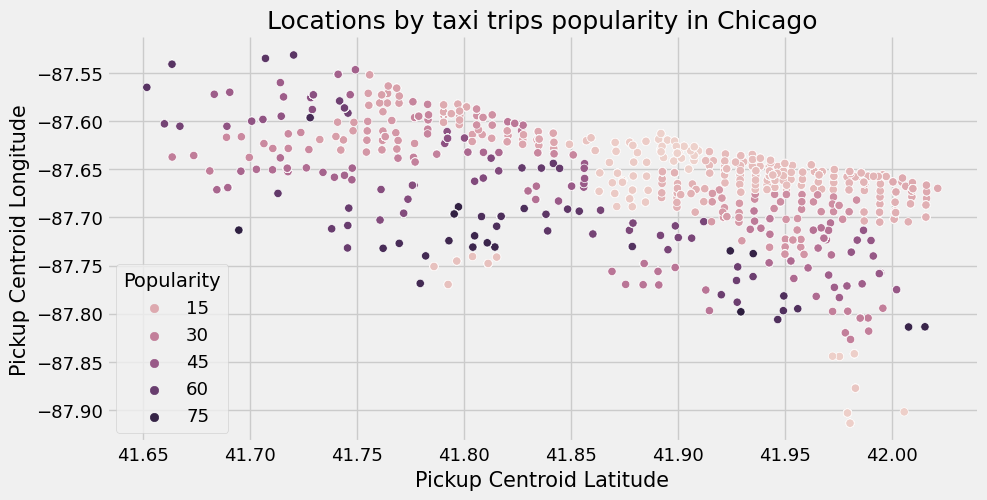

In [54]:
plt.figure(figsize=(10, 5))
geo_plot = sns.scatterplot(
    data=geo_features_pickup,
    x="Pickup Centroid Latitude",
    y="Pickup Centroid Longitude",
    hue="Popularity",
)
plt.title("Locations by taxi trips popularity in Chicago");

Least popular locations seem to predominantly be situated at the edges of the city.

In [55]:
popular_locations_top = popularity.head(5)

In [56]:
unpopular_locations_top = popularity.tail(5)

### Time features for trips count and payment total

For trips count and total hourly revenue, rolling mean and lag features will be added.

In [57]:
counts = grouped.count()
trip_total_aggs = agg_2_sum_and_median.select(["date", "location", "trip_total_agg"])

In [58]:
trips_count = counts.join(trip_total_aggs, on=["date", "location"], how="left")

In [59]:
trips_count = trips_count.toPandas()

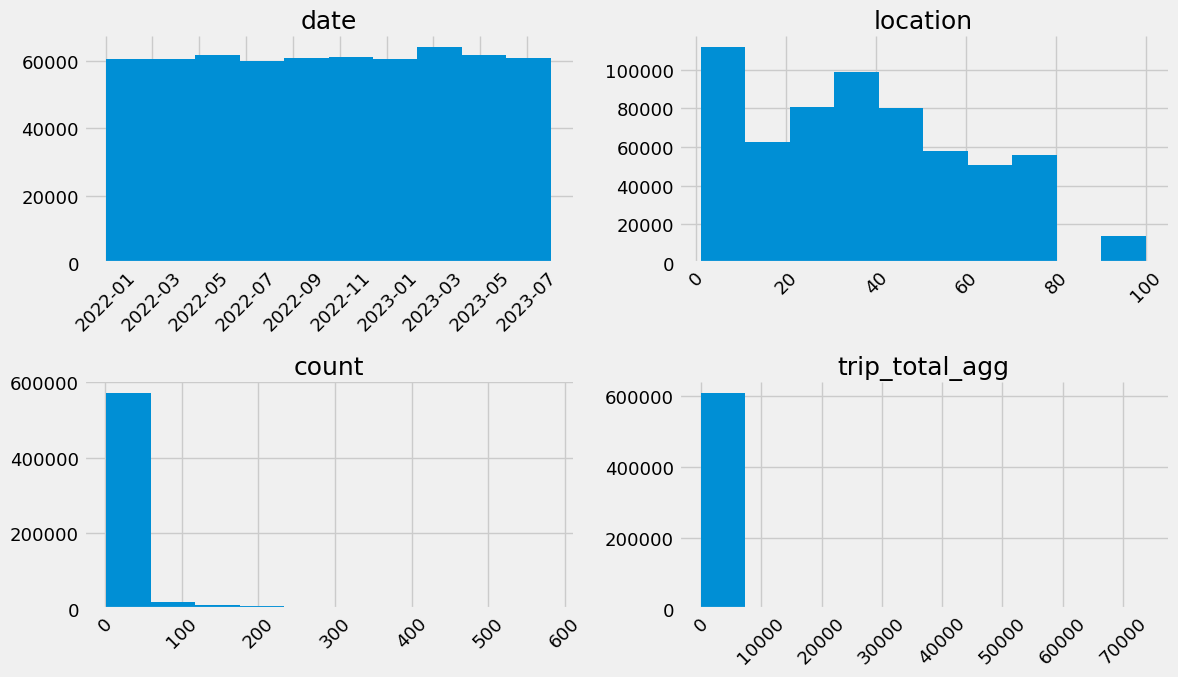

In [60]:
trips_count.hist(figsize=(12, 7), xrot=45)
plt.tight_layout()

Taking a closer look at the taxo trips count:

In [61]:
trips_count_grouped = trips_count.groupby(["date"]).sum().drop("location", axis=1)

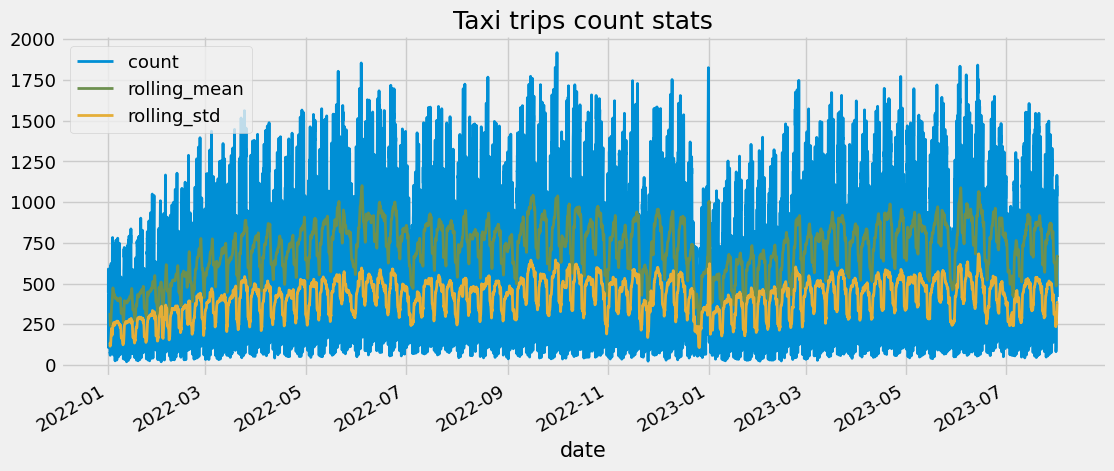

In [62]:
trips_count_grouped["count"].plot(figsize=(12, 5))
trips_count_grouped["count"].shift().rolling(24).mean().plot(color="#6d904f")
trips_count_grouped["count"].shift().rolling(24).std().plot(color="#e5ae38")
plt.title("Taxi trips count stats")
plt.legend(["count", "rolling_mean", "rolling_std"])
plt.show()

The mean and std seem to be non-stationary. There seems to be seasonality in data. STL decomposition will be used to get more valuable information:

In [63]:
trips_count_grouped = trips_count_grouped["count"]  # convert to series
trips_count_grouped = trips_count_grouped.resample("H").sum()  # fake resample to fit in STL

In [64]:
df_decomposed = STL(trips_count_grouped, robust=True).fit()

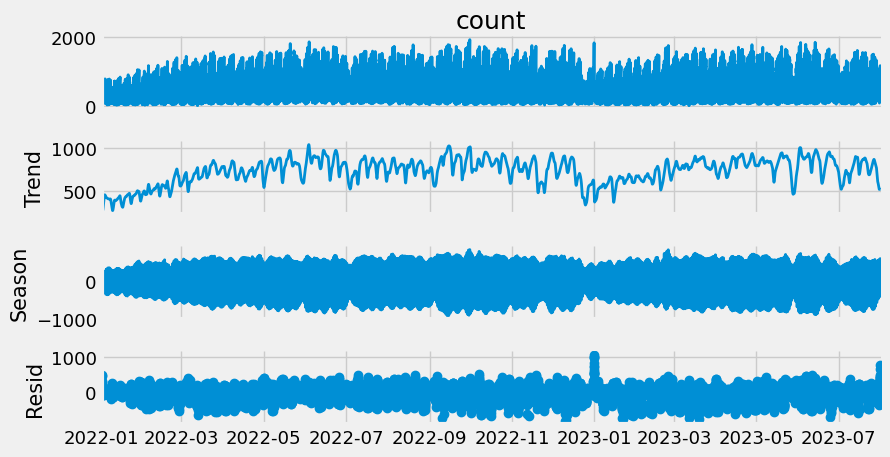

In [65]:
fig = df_decomposed.plot()
fig.set_figwidth(10)

The trend tells us that there is less trips overall in Jan and Feb while in other months there are fluctuations from 500 to 1000 daily trips without explicit trend. There is daily seasonality with mean value that looks stationary. In more detail:

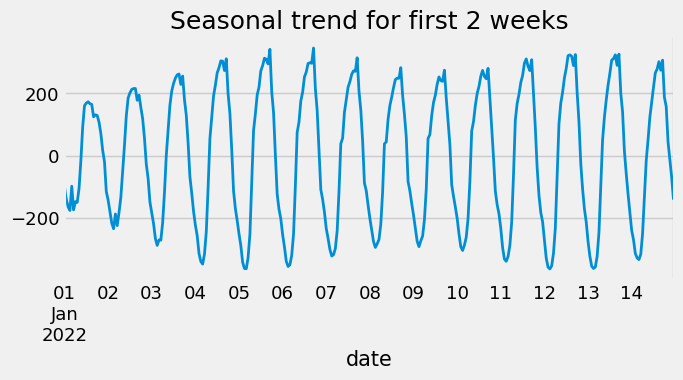

In [66]:
df_decomposed.seasonal.head(24 * 14).plot(figsize=(7, 3))
plt.title("Seasonal trend for first 2 weeks")
plt.show()

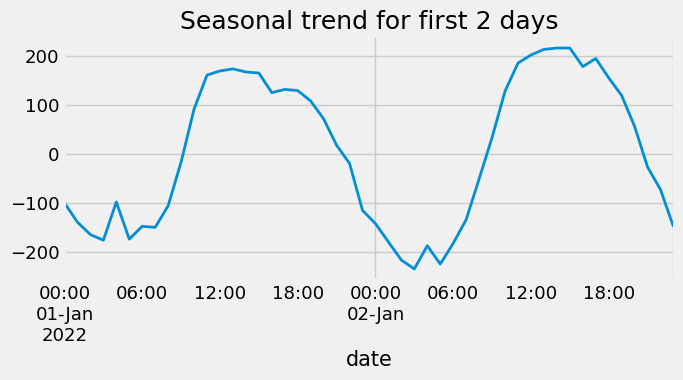

In [67]:
df_decomposed.seasonal.head(2 * 24).plot(figsize=(7, 3))
plt.title("Seasonal trend for first 2 days")
plt.show()

---

Optimal values for rolling mean size and lag features count will be calculated using custom function.  
It finds the optimal values for these parameters, as well as the necessity to add the STL decomposed features.

The optimal parameters will be calculated using Linear Regression predictions for only one popular community area (location), but will further be used for all other locations as well.

In [68]:
popularity.head(3)

8     1.0
76    2.0
32    3.0
Name: Pickup Community Area, dtype: float64

In [69]:
popular_location = popularity.index.tolist()[2]

In [70]:
# find best params for a popular location

df = (
    trips_count[trips_count["location"] == popular_location]
    .drop("location", axis=1)
    .set_index("date")
    .resample("1H")
    .sum()
)

cv_params = {
    "max_lag": [1, 12, 24, 30, 40, 48, 60, 72, 168],
    "rolling_mean_size": [1, 12, 15, 20, 24, 48, 72],
    "add_decomposed": [False, True],
}

data = TSDataManager(df)
cv_result = data.grid_search(LinearRegression(), cv_params)

100%|██████████| 126/126 [02:37<00:00,  1.25s/it]


In [71]:
# optimal parameters
cv_result

{'best_score_RMSE': 21.10709582978574,
 'best_params': {'max_lag': 168,
  'rolling_mean_size': 12,
  'add_decomposed': True},
 'best_model': LinearRegression()}

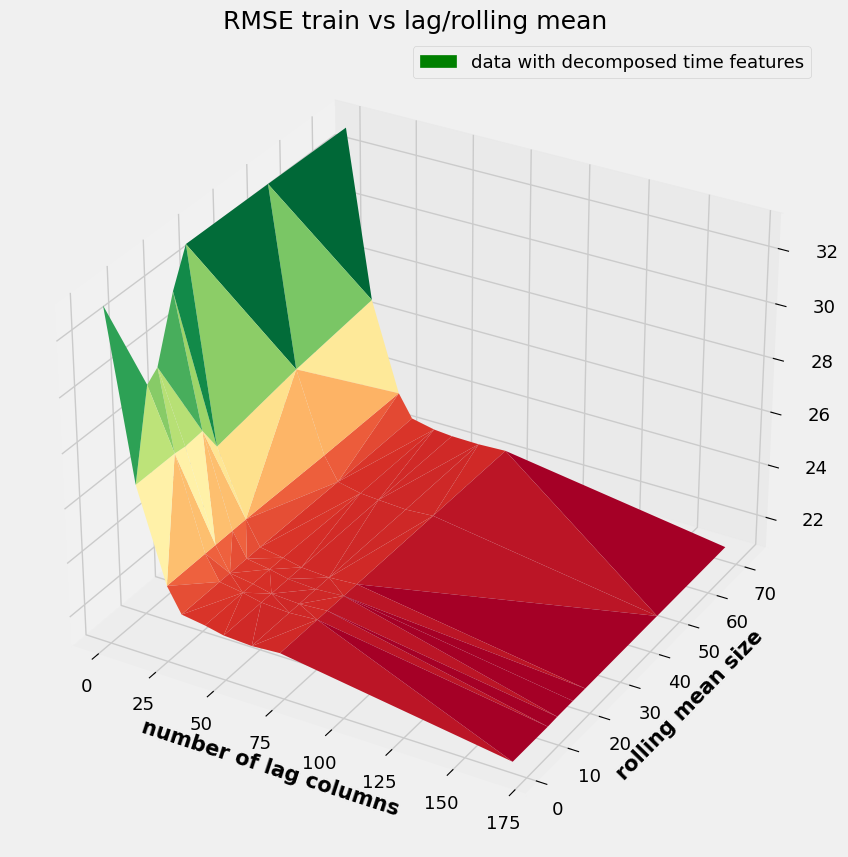

In [72]:
data.plot(plot_non_decomposed=False);

168 lag columns (1 week) and 12 hours rolling mean size (half a day) are the optimal parameters that will be used for feature generation for all locations.  
  
Lag and rolling mean columns for trips count and aggregate hourly revenue will be created separately for every location. Then the resulting dfs for every location will be concatenated.

In [73]:
def make_time_features_by_location(input_df, ts_params):
    """
    Makes lags / rolling mean for every location separately, then concatenates dfs for every location.
    """
    # same functionality is achievable using groupby instead of loop. but no

    dfs_with_added_time_features = dict()
    input_df = input_df.copy()

    for i in tqdm(input_df.location.unique()):
        df = input_df[input_df["location"] == i].drop("location", axis=1).set_index("date").resample("1H").sum()

        data = TSDataManager(df)

        _, modified_df = data.make_features(**ts_params)
        modified_df.insert(0, "location", i)

        dfs_with_added_time_features[i] = modified_df.copy()

    time_features = pd.concat([df for df in dfs_with_added_time_features.values()])
    return time_features

In [74]:
best_ts_params = cv_result["best_params"]
best_ts_params["rolling_mean_size"] = 12

time_features = make_time_features_by_location(trips_count, best_ts_params)

100%|██████████| 78/78 [02:53<00:00,  2.22s/it]


In [75]:
# time_features = time_features[time_features['count'] > 0]  # remove all hours without trips
# assert len(time_features) == len(trips_count)

## Machine learning

### Merging dfs and final data preparation

Join the time features and non-time features:

In [76]:
final_df = time_features.merge(
    non_time_features, left_on=["date", "location"], right_on=["date", "location"], how="left"
)

In [77]:
final_df = final_df.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))  # rename columns to be machine readable
final_df = final_df.loc[:, ~final_df.columns.duplicated()].copy()  # drop duplicate columns, if any
final_df = final_df.set_index("date")

In [78]:
# remove first week containing gaps in lag columns
final_df = final_df[START_DATE:]

Fill the first hour with 0 trips using the data from previous hour, fill all other rows with 0:

In [79]:
final_df = final_df.sort_values(["location", "date"])

In [80]:
final_df = final_df.fillna(method="ffill", limit=1)  # fill 0-trip hours with previous hour values
final_df = final_df.fillna(0)

Add an artificial feature that clusters the regions by relatively large prediction error and geographical proximity.

In [81]:
# clusterize regions with worse predictions by geographical proximity

cluster_dict = dict()

pop_dict = {
    1: [11, 12, 15, 17, 18, 20],
    2: [23, 26],
    3: [30, 31],
    4: [47, 50, 51, 52, 54, 55],
    5: [63, 65, 67],
    6: [72, 74],
}

for key, value in pop_dict.items():
    for el in value:
        cluster_dict[el] = key

In [82]:
final_df["cluster"] = final_df["location"].map(cluster_dict)
final_df["cluster"] = final_df["cluster"].fillna(0)

In [83]:
final_df.head(5)

,location,count,count_lag_1,count_lag_2,count_lag_3,count_lag_4,count_lag_5,count_lag_6,count_lag_7,count_lag_8,...,tolls_median_lag1,extras_agg_lag1,extras_median_lag1,trip_total_agg_lag1,trip_total_median_lag1,mean_speed_median_lag1,pickup_census_mode_lag1,dropoff_census_mode_lag1,popularity,cluster
date,,,,,,,,,,,,,,,,,,,,,
2022-01-08 00:00:00,1,2,2.0,1.0,5.0,4.0,3.0,3.0,5.0,12.0,...,0.0,0.0,0.0,43.50,21.75,24.931073,1.704901e+10,1.704901e+10,15.0,0.0
2022-01-08 01:00:00,1,1,2.0,2.0,1.0,5.0,4.0,3.0,3.0,5.0,...,0.0,0.0,0.0,11.00,5.50,12.610315,1.704901e+10,1.704901e+10,15.0,0.0
2022-01-08 02:00:00,1,1,1.0,2.0,2.0,1.0,5.0,4.0,3.0,3.0,...,0.0,0.0,0.0,8.00,8.00,11.071429,1.704901e+10,1.704901e+10,15.0,0.0
2022-01-08 03:00:00,1,2,1.0,1.0,2.0,2.0,1.0,5.0,4.0,3.0,...,0.0,0.0,0.0,11.75,11.75,9.782609,1.704901e+10,1.704901e+10,15.0,0.0
2022-01-08 04:00:00,1,2,2.0,1.0,1.0,2.0,2.0,1.0,5.0,4.0,...,0.0,0.0,0.0,28.00,14.00,20.388927,1.704901e+10,1.704901e+10,15.0,0.0


### Train/test split

Size of train data is 70%, validation and test data are both 15%.

In [84]:
val_iloc = -int(len(final_df.index.unique()) * 2 * TEST_SIZE)
test_iloc = -int(len(final_df.index.unique()) * TEST_SIZE)

val_index = final_df.index.unique()[val_iloc]
test_index = final_df.index.unique()[test_iloc]

In [85]:
str(val_index)

'2023-02-11 00:00:00'

In [86]:
str(test_index)

'2023-05-07 12:00:00'

In [87]:
X_train = final_df.drop("count", axis=1).loc[: str(val_index)]
y_train = final_df["count"].loc[: str(val_index)]


X_valid = final_df.drop("count", axis=1).loc[str(val_index) : str(test_index)]
y_valid = final_df["count"].loc[str(val_index) : str(test_index)]


X_test = final_df.drop("count", axis=1).loc[str(test_index) :]
y_test = final_df["count"].loc[str(test_index) :]

In [88]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(747006, 416)
(160134, 416)
(159861, 416)


### Getting predictions (Approach I, aggregate predictions)

The first approach is to have 1 model for all data. An ensemble of LGBMRegressor and CatBoost regressor is used for this purpose.

In [89]:
gbm_params = {
    "learning_rate": 0.1,
    "max_bin": 255,
    "n_estimators": 1000,
    "num_leaves": 400,
    "max_depth": 20,
    "early_stopping_round": 50,
}

In [90]:
gbm = lgb.LGBMRegressor(n_jobs=-1, application="regression", metric="mae", **gbm_params)
gbm.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric="mae", verbose=-1)

preds_gbm = gbm.predict(X_valid)
mean_absolute_error(y_valid, preds_gbm)

1.6562918212175235

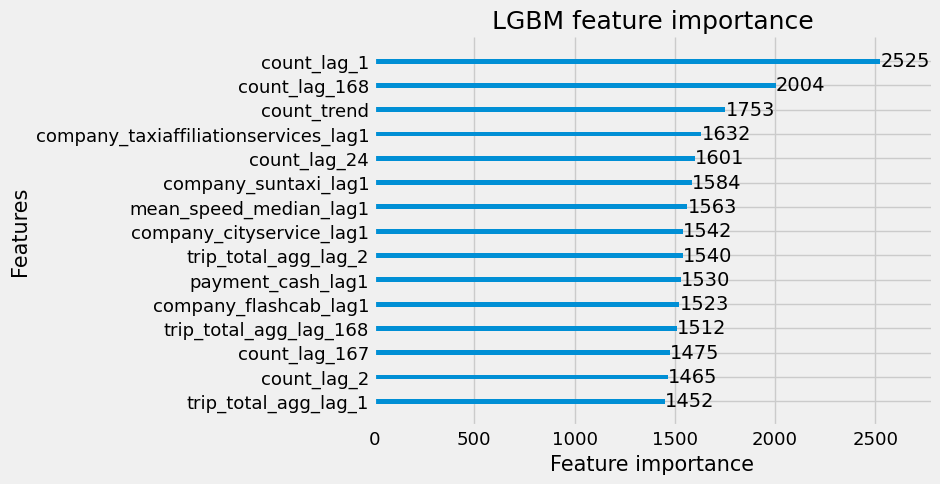

In [91]:
lgb.plot_importance(gbm, max_num_features=15, title="LGBM feature importance")
plt.show()

Most important features for LGBM are trips count for previous hour, trips count a week ago and the trend of trips count from STL decomposition.

In [97]:
cbr_params = {
    "iterations": 3000,
    "learning_rate": 0.3,
    "max_leaves": 400,
    "thread_count": -1,
    "loss_function": "MAE",
    "grow_policy": "Lossguide",
    "langevin": True,
    "early_stopping_rounds": 50,
    "boosting_type": "Plain",  # should increase speed
    "verbose": 500,
    "eval_metric": "MAE",
}

In [98]:
cbr = CatBoostRegressor(**cbr_params)
cbr.fit(X_train, y_train, eval_set=(X_valid, y_valid))

preds_cbr = cbr.predict(X_valid)
mean_absolute_error(y_valid, preds_cbr)

0:	learn: 7.6175701	test: 8.2595865	best: 8.2595865 (0)	total: 635ms	remaining: 31m 45s
500:	learn: 1.3509613	test: 1.7187801	best: 1.7187801 (500)	total: 5m 50s	remaining: 29m 10s
1000:	learn: 1.2200443	test: 1.6748479	best: 1.6748479 (1000)	total: 11m 59s	remaining: 23m 57s
1500:	learn: 1.1658188	test: 1.6529458	best: 1.6529314 (1496)	total: 18m 8s	remaining: 18m 7s
2000:	learn: 1.1491055	test: 1.6395204	best: 1.6395204 (2000)	total: 23m 55s	remaining: 11m 56s
2500:	learn: 1.1501992	test: 1.6290863	best: 1.6290568 (2499)	total: 29m 27s	remaining: 5m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.626514081
bestIteration = 2663

Shrink model to first 2664 iterations.


1.629071619103671

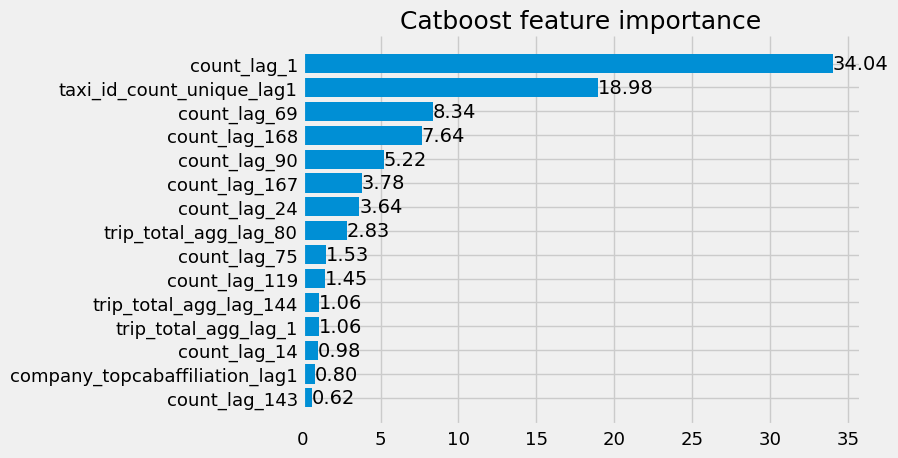

In [99]:
fi = pd.Series(cbr.feature_importances_, index=cbr.feature_names_).sort_values(ascending=False)
fi_short = fi[:15][::-1]

ax = plt.barh(fi_short.index, fi_short.values)
plt.bar_label(ax, fmt="%.2f")
plt.title("Catboost feature importance")
plt.show()

Most important features for CatBoost are trips count for previous hour, trips count a week ago and the count of unique taxi ids for the previous hour.

Getting the final combined prediction:

In [100]:
combined = (0.75 * preds_gbm + 1.25 * preds_cbr) / 2
combined = list(map(lambda x: x if x >= 0 else 0, combined))

All the values less than 0 are zeroed as there can't be less than 0 trips per hour. Final MAE score for first approach:

In [101]:
mean_absolute_error(y_valid, combined)

1.5963994919565152

### Getting predictions (Approach II, separate predictions)

The second approach is to have 1 model for every location (community area). Mean MAE for all regions is used as a metric in this case.

In [102]:
cbr_params = {
    "iterations": 3000,
    "learning_rate": 0.2,
    "max_leaves": 400,
    "thread_count": -1,
    "loss_function": "MAE",
    "grow_policy": "Lossguide",
    "langevin": True,
    "early_stopping_rounds": 100,
    "boosting_type": "Plain",  # should increase speed
    "logging_level": "Silent",
    "eval_metric": "MAE",
}

In [103]:
gbm_params = {
    "learning_rate": 0.2,  # has no impact
    "max_bin": 255,
    "n_estimators": 1000,
    "num_leaves": 400,
    "early_stopping_round": 50,
    "max_depth": 20,
}

In [104]:
predictions = []

for i in tqdm(X_train["location"].unique()):
    X_train_subset = X_train[X_train["location"] == i]
    y_train_subset = y_train[X_train["location"] == i]

    X_valid_subset = X_valid[X_valid["location"] == i]
    y_valid_subset = y_valid[X_valid["location"] == i]

    cbr = CatBoostRegressor(**cbr_params)
    cbr.fit(X_train_subset, y_train_subset, eval_set=(X_valid_subset, y_valid_subset))

    gbm = lgb.LGBMRegressor(metric="mae", **gbm_params)
    gbm.fit(
        X_train_subset,
        y_train_subset,
        eval_set=(X_valid_subset, y_valid_subset),
        eval_metric="mae",
        verbose=-1
    )

    preds_gbm_partial = gbm.predict(X_valid_subset)
    preds_cbr_partial = cbr.predict(X_valid_subset)

    combined_partial = (0.75 * preds_gbm_partial + 1.25 * preds_cbr_partial) / 2
    combined_partial = list(map(lambda x: x if x >= 0 else 0, combined_partial))

    predictions.append(mean_absolute_error(y_valid_subset, combined_partial))

100%|██████████| 78/78 [22:02<00:00, 16.96s/it] 


Final mean MAE:

In [105]:
sum(predictions) / len(predictions)

1.6884655194279896

This approach is faster but the resulting metric looks worse than that for the 1st approach. However, it is a different metric, and it will be fair to compare mean MAEs for all regions in order to determine a better approach.

### Comparing two approaches

Adding MAEs for every region for the "separate models" approach to a df:

In [106]:
prediction_stats = trips_count.groupby("location").sum()

In [107]:
prediction_stats["preds"] = predictions
prediction_stats["normalized_preds"] = 10e5 * prediction_stats["preds"] / prediction_stats["count"]

A custom normalized MAE metric (MAE divided by trips count in the region) is used for a better comparison and identifying outliers in predictions.

Adding MAEs for every region for the "aggregate" (one model) approach to a df:

In [108]:
agg_preds = X_valid.copy()
agg_preds["predictions"] = combined
agg_preds = agg_preds[["location", "predictions"]]
agg_preds["y_valid"] = y_valid

In [109]:
predictions_agg_method = []

location_idx = [i for i in range(1, 78)]
location_idx.append(100)

for i in location_idx:
    grouped_by_loc = agg_preds[agg_preds["location"] == i]
    predictions_agg_method.append(mean_absolute_error(grouped_by_loc["y_valid"], grouped_by_loc["predictions"]))

In [110]:
prediction_stats["preds_aggregate"] = predictions_agg_method
prediction_stats["normalized_preds_aggregate"] = 10e5 * prediction_stats["preds_aggregate"] / prediction_stats["count"]

Applying function to determine an approach that provides lower MAE:

In [111]:
def define_better_method(row):
    if row["preds"] < row["preds_aggregate"]:
        return "separate"
    else:
        return "aggregate"

In [112]:
prediction_stats["better_method"] = prediction_stats.apply(define_better_method, axis=1)
prediction_stats["better_method"].value_counts()

aggregate    78
Name: better_method, dtype: int64

First, "aggregate" approach is better in every case. This is also shown by the following figure:

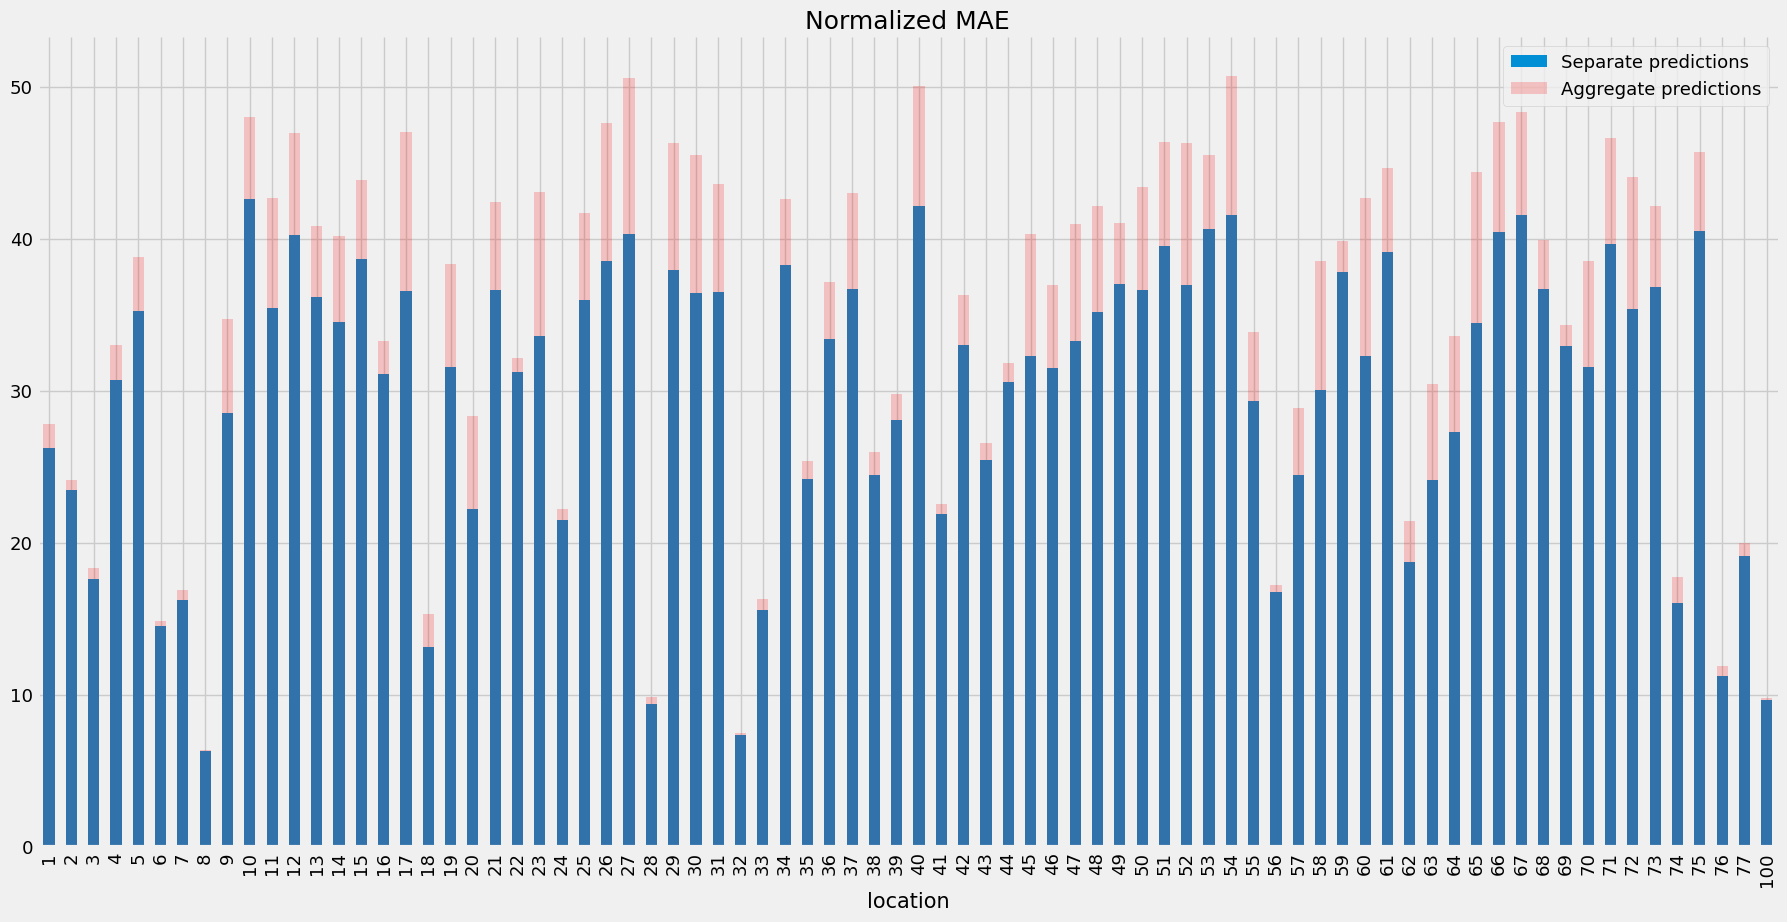

In [113]:
prediction_stats["normalized_preds_aggregate"].plot(kind="bar", title="Normalized MAE")
prediction_stats["normalized_preds"].plot(kind="bar", figsize=(20, 10), alpha=0.2, color="red")

plt.legend(["Separate predictions", "Aggregate predictions"]);

Plots for normalized and regular MAE:

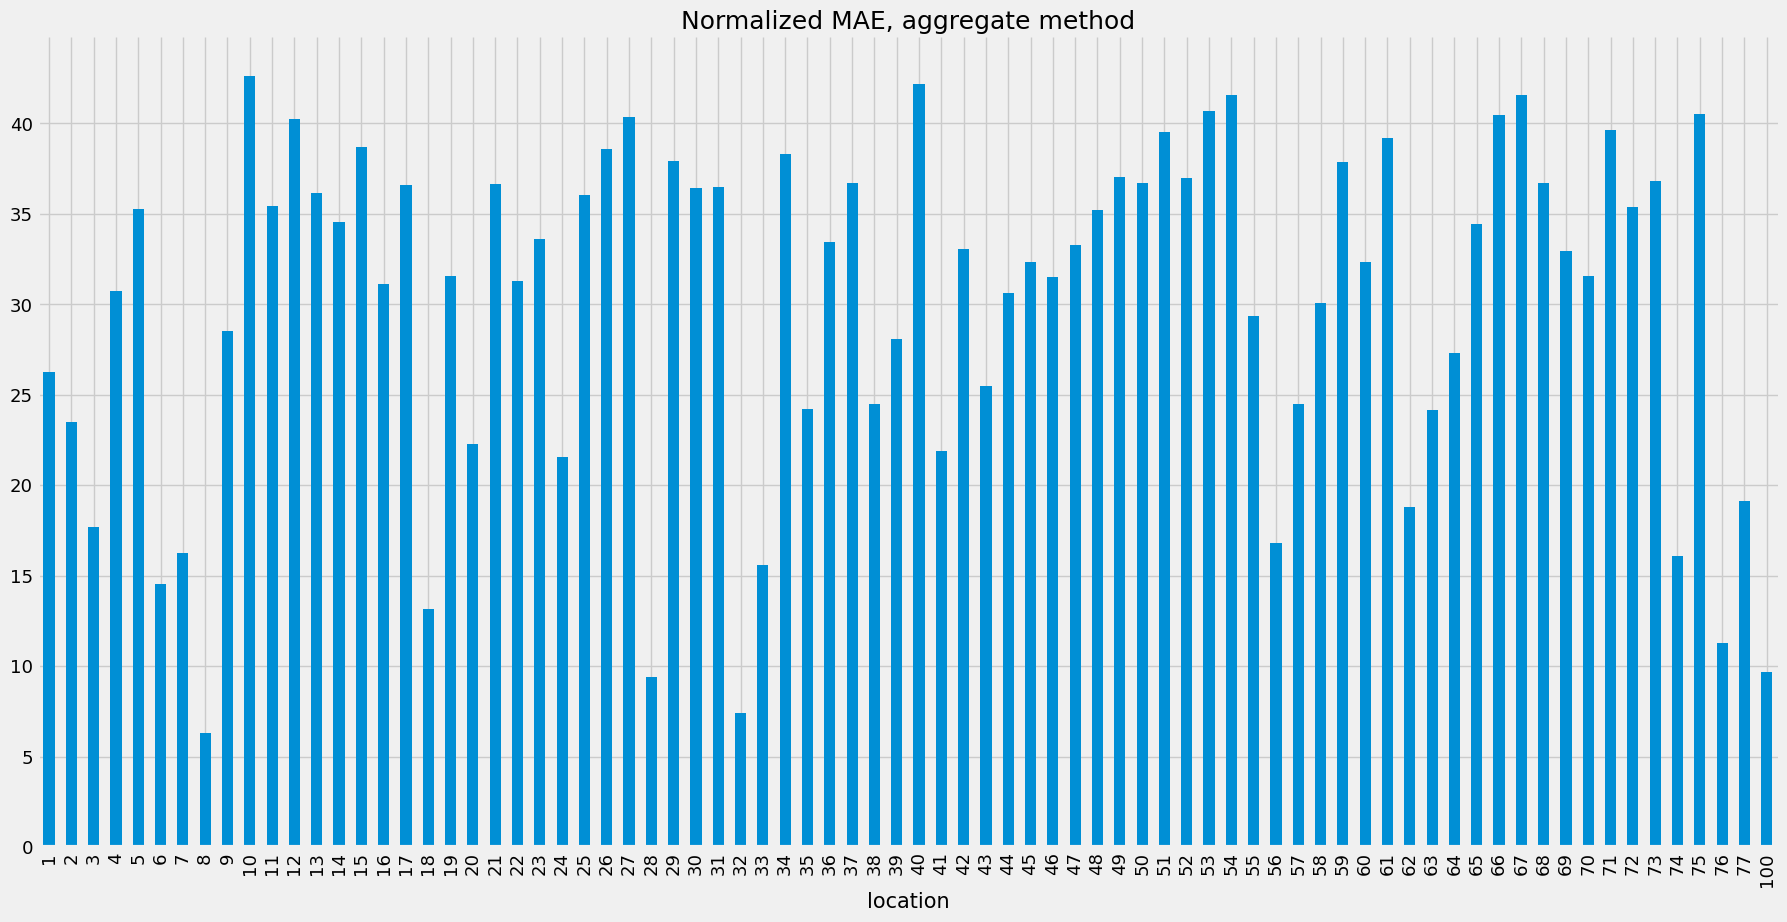

In [114]:
prediction_stats["normalized_preds_aggregate"].plot(
    kind="bar", figsize=(20, 10), title="Normalized MAE, aggregate method"
);

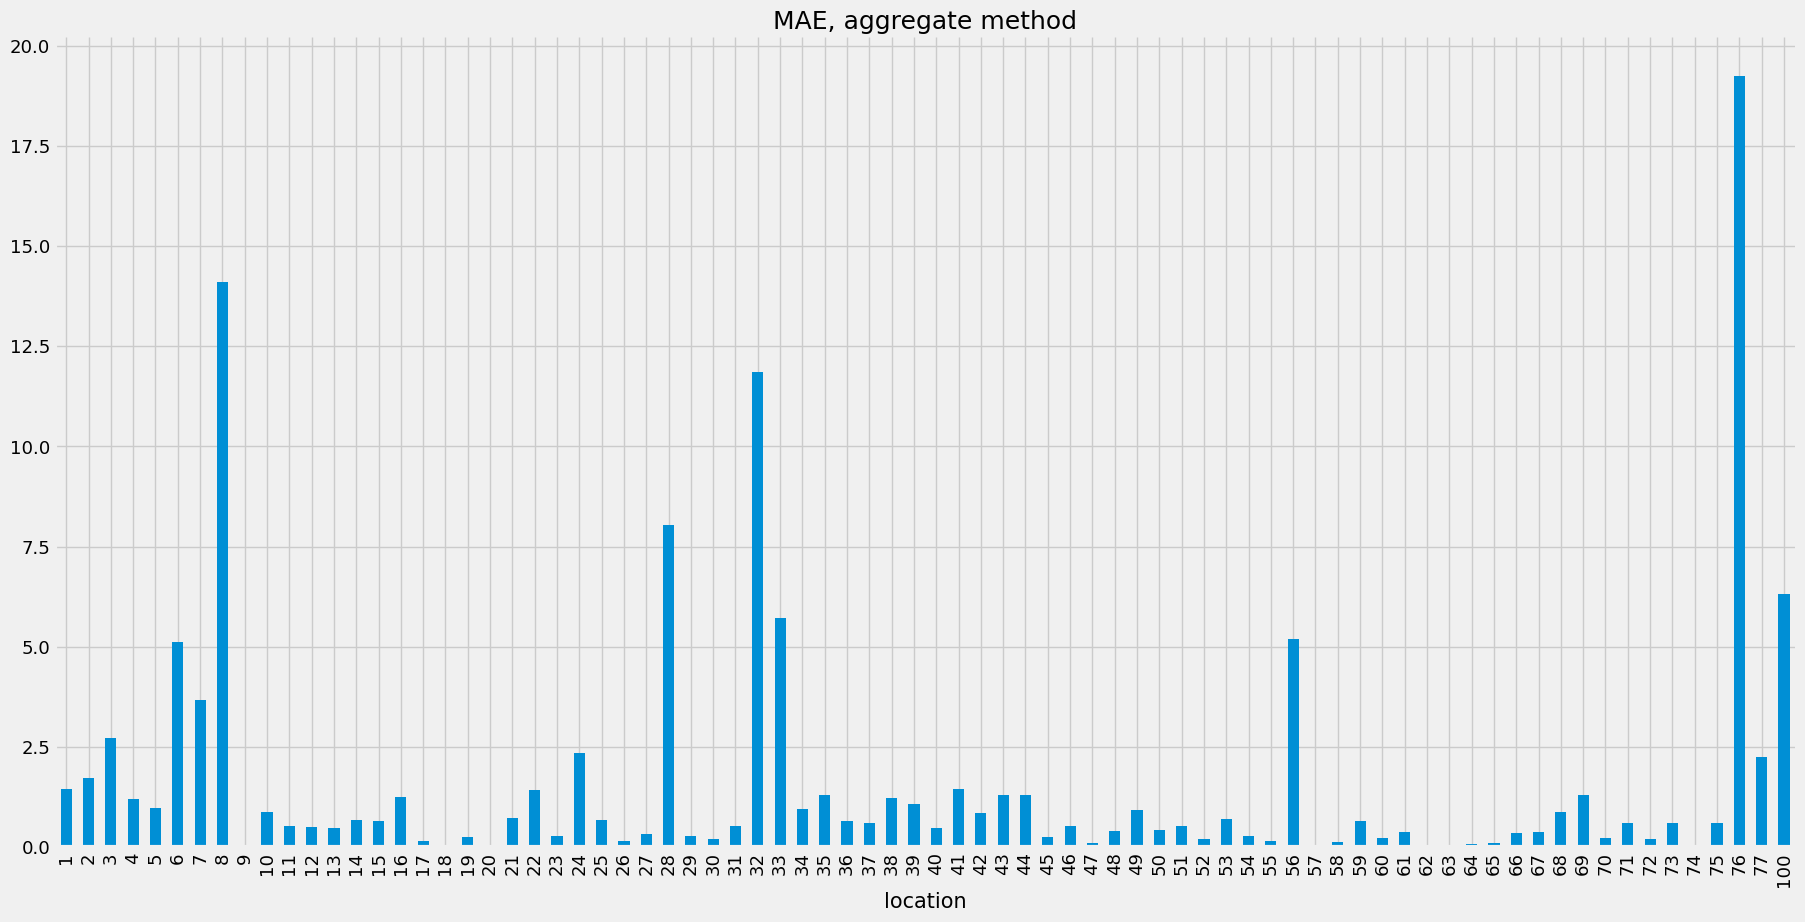

In [115]:
prediction_stats["preds_aggregate"].plot(kind="bar", figsize=(20, 10), title="MAE, aggregate method");

The normalized MAE metric is better for the locations with more trips (e.g. 8, 32) which means that the resulting model gets overall better predictions for these community areas. The MAE metric is at the same time higher for these regions.

### Trying to get better predictions for one of "bad" regions

The bad regions are the ones with high normalized MAE. Such regions have a low number of trips. Prediction of trips count using median values for hour and day of week, or usin only a small subset of features may provide better results for such regions. Below is an example for community area #10.

In [116]:
REGION = 10

In [117]:
for_bad_region = agg_preds[agg_preds["location"] == REGION]

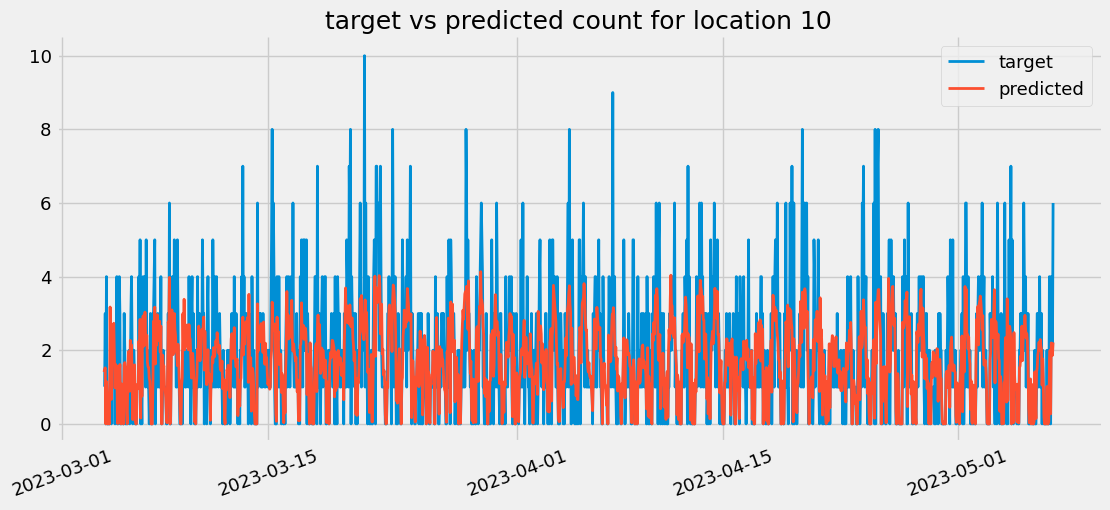

In [118]:
plt.figure(figsize=(12, 5))
plt.plot(for_bad_region["y_valid"][500:], label="target")
plt.plot(for_bad_region["predictions"][500:], label="predicted")
plt.xticks(rotation=20)
plt.title(f"target vs predicted count for location {REGION}")
plt.legend()
plt.show()

The figure for this location shows bad prediction quality.

#### Using less features

In [119]:
X_train_bad_region = X_train[X_train["location"] == REGION][["hour", "dayofweek"]]
y_train_bad_region = y_train[X_train["location"] == REGION]

In [120]:
X_valid_bad_region = X_valid[X_valid["location"] == REGION][["hour", "dayofweek"]]
y_valid_bad_region = y_valid[X_valid["location"] == REGION]

In [121]:
gbm_params_dummy = {
    "learning_rate": 0.1,  # has no impact
    "max_bin": 255,
    "n_estimators": 1000,  # leaving only best params to speed up the notebook :)
    "num_leaves": 400,
    "max_depth": 20,
}

In [122]:
gbm = lgb.LGBMRegressor(application="regression", metric="mae", **gbm_params_dummy)

In [123]:
gbm.fit(X_train_bad_region, y_train_bad_region)
preds_bad_region = gbm.predict(X_valid_bad_region)
mean_absolute_error(y_valid_bad_region, preds_bad_region)

1.0960471573866344

Using less features makes MAE slightly worse.

#### Using median

In [124]:
X_valid_bad_region = X_valid[X_valid["location"] == REGION]
y_valid_bad_region = y_valid[X_valid["location"] == REGION]

In [125]:
X_train_bad_region = X_train[X_train["location"] == REGION]
y_train_bad_region = y_train[X_train["location"] == REGION]

In [126]:
def predict_median(row):
    return preds_dow_hour[row["dayofweek"], row["hour"]]


preds_dow_hour = X_train_bad_region.join(y_train_bad_region).groupby(["dayofweek", "hour"])["count"].median()
mean_absolute_error(y_valid_bad_region, X_valid_bad_region.apply(predict_median, axis=1))

1.0823185582075012

#### Using regular approach

In [127]:
gbm = lgb.LGBMRegressor(application="regression", metric="mae", **gbm_params_dummy)

In [128]:
gbm.fit(X_train_bad_region, y_train_bad_region)
preds_bad_region = gbm.predict(X_valid_bad_region)
mean_absolute_error(y_valid_bad_region, abs(preds_bad_region))

1.0439180423793453

In [129]:
pr = list(map(lambda x: x if x >= 0 else 0, preds_bad_region))

In [130]:
mean_absolute_error(y_valid_bad_region, pr)

1.0430915421307352

MAE for this region using the regular boosting approach is 1.04.

Using median by day of week and hour provides worse MAE than regular boosting approach. Therefore, the best way is to use the regular boosting.

## Conclusion

An ensemble of LGBM regressor and CatBoost regressor is proposed as a method of prediction of taxi trips count for the next hour for Chicago taxi trips dataset. Two approaches were compared: using 1 model for all predictions, using a separate model for each community area, with first providing significantly better reults. Resulting MAE for predictions with the better approach is 1.59.